In [1]:
from netCDF4 import Dataset
import datetime
import matplotlib.pyplot as plt
from scipy.stats import binned_statistic
import pandas as pd
import os
import numpy as np
from scipy.signal import argrelextrema
import pickle
import warnings
from scipy.stats import pearsonr

In [2]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import pymannkendall as mk
import matplotlib.cm as cmx
import numpy as np

In [3]:
directory = '../data/PROCESSED'

In [4]:
def get_time_ticks(times):
    seconds = [t.second for t in times]
    hours = [t.hour for t in times]
    minutes = [t.minute for t in times]
    time_ticks = [f'{h}:{str(m).zfill(2)}:{str(s).zfill(2)}' for h,m,s in zip(hours, minutes, seconds)]
    return time_ticks

pits = {}

def plot_file(f,band):
    
    if band.lower()=='ka':
        
        skipper = 100
        ylims = (1000,570)
        
    elif band.lower()=='ku':
        skipper=40
        ylims = (600,400)
        
    else:raise
    
    with Dataset(f'{directory}/{f}') as d:
        ranges = np.array(d['range'])
        times = np.array([datetime.datetime(1970,1,1)+datetime.timedelta(seconds=int(x)) for x in d['start_time']])

        time_ticks = get_time_ticks(times)

        hh = np.array(d['hh_power_decon0'])
        vv = np.array(d['vv_power_decon0'])

        plt.figure(figsize=(10,4))
        plt.imshow(np.log(hh),aspect='auto')
        plt.xticks(np.arange(0,hh.shape[1],skipper),labels=time_ticks[::skipper],rotation=90)

        plt.yticks(np.arange(0,hh.shape[0],skipper),labels=ranges[::skipper])

        plt.ylim(ylims[0],ylims[1])
        plt.show()

In [5]:
'/home/robbie/Dropbox/kuka_height_ex/data/PROCESSED/20230529'

'/home/robbie/Dropbox/kuka_height_ex/data/PROCESSED/20230529'

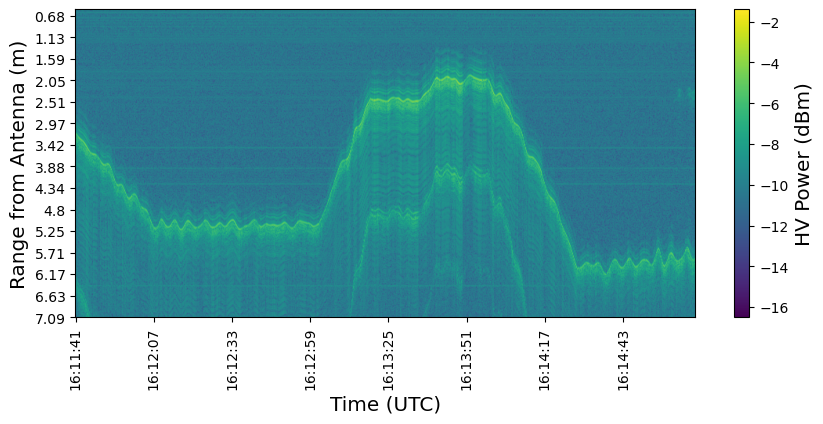

In [8]:
skipper = 100
ylims = (2000,570)
    
a = 'kuka_stare_decon_Ka-Scat20230529-161141.nc'

b = 'kuka_stare_decon_Ka-Scat20230529-160641.nc'

with Dataset(f'/home/robbie/Dropbox/kuka_height_ex/data/PROCESSED/20230529/{a}') as d:
    ranges = np.array(d['range'])
    times = [datetime.datetime(1970,1,1)+datetime.timedelta(seconds=int(x)) for x in d['start_time']]

    time_ticks = get_time_ticks(times)

    p = np.array(d['hv_power_decon0'])
    
    plt.figure(figsize=(10,4))
    plt.imshow(np.log10(p),aspect='auto')
    plt.xticks(np.arange(0,p.shape[1],skipper),labels=time_ticks[::skipper],rotation=90)

    plt.yticks(np.arange(0,p.shape[0],skipper),labels=[str(round(x,2)) for x in ranges[::skipper]])

    cb = plt.colorbar()
    cb.set_label('HV Power (dBm)',fontsize='x-large')
    
    plt.ylabel('Range from Antenna (m)',fontsize='x-large')
    plt.xlabel('Time (UTC)',fontsize='x-large')
    
    plt.ylim(ylims[0],ylims[1])
    plt.show()
    

range_res = np.diff(ranges)[0]
window_ranges = np.arange(-10*range_res,10*range_res+1e-10,range_res)

In [9]:
range_mask = np.ones(ranges.shape[0])

range_mask[ranges<1.5] = 0
range_mask[ranges>6.6] = 0

range_mask_2d = np.repeat([range_mask],793,axis=0).T

hhm = p*range_mask_2d*1000

argmax = np.argmax(hhm,axis=0)

max_ranges = ranges[argmax]

max_powers = np.max(hhm,axis=0)

window_size=10


x = np.linspace(window_ranges[0],window_ranges[-1],100)

peaks = []
fwhms = []

a,b = 0,680

for i in range(a,b):

    max_power_range_ind = argmax[i]
    
    peak = hhm[max_power_range_ind-window_size:max_power_range_ind+window_size+1,i]
    

    poly = np.polyfit(window_ranges,peak,deg=13)
    s = np.poly1d(poly)
    y = s(x)
    polypeakargmax = np.argmax(y)
    polypeakmax = np.max(y)
    fwhm = x[polypeakargmax + np.argmin(y[polypeakargmax:]>polypeakmax/2)] - x[np.argmax(y>polypeakmax/2)]
    

    peaks.append(peak)
    fwhms.append(fwhm)
    
jet = cm = plt.get_cmap('rainbow') 
cNorm  = colors.Normalize(vmin=0, vmax=np.max(np.array(max_ranges).flatten()))
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)

dt0 = times[0]

secs = [(t-dt0).seconds for t in times]


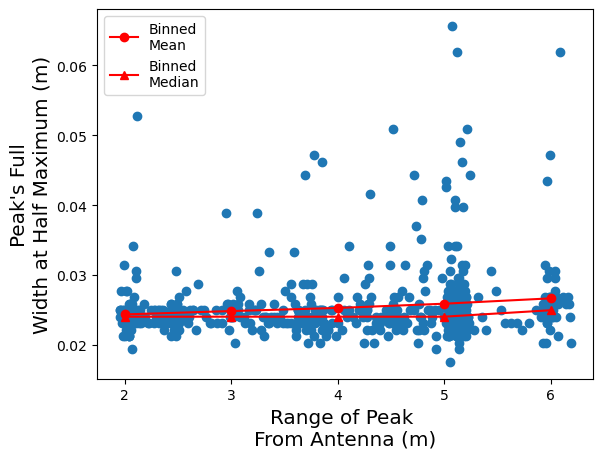

In [22]:
plt.scatter(max_ranges[:b],fwhms)

stat = binned_statistic(max_ranges[:b],fwhms,'mean',bins=np.arange(1.5,6.51,1))
plt.plot([2,3,4,5,6],stat[0],color='r',marker='o',label='Binned\nMean')

stat = binned_statistic(max_ranges[:b],fwhms,'median',bins=np.arange(1.5,6.51,1))
plt.plot([2,3,4,5,6],stat[0],color='r',marker='^',label='Binned\nMedian')

plt.ylabel("Peak's Full\nWidth at Half Maximum (m)",fontsize='x-large')
plt.xlabel("Range of Peak \nFrom Antenna (m)",fontsize='x-large')

plt.legend()

In [11]:
df = pd.DataFrame({'r':max_ranges[:b],'w':fwhms})
df.sort_values('r',inplace=True)

result = mk.original_test(df['w'])
print(result)

Mann_Kendall_Test(trend='increasing', h=True, p=0.002069956287445107, z=3.0800071455541236, Tau=0.07849345923936585, s=18121.0, var_s=34610903.666666664, slope=0.0, intercept=0.024044152462121215)


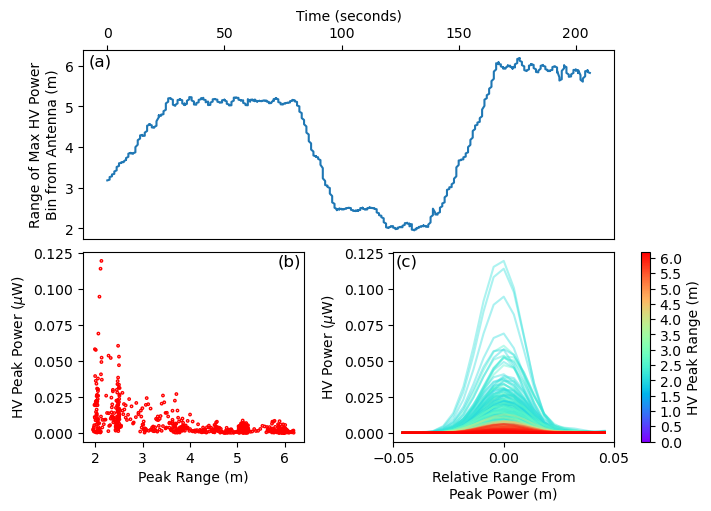

In [21]:
fig = plt.figure(constrained_layout=True,figsize=(7,5))

gs = fig.add_gridspec(2, 2)

ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1:, -1])


ax1.plot(secs,max_ranges)
# ax1.set_xticks(dt_ticks)
ax1.set_ylabel('Range of Max HV Power\nBin from Antenna (m)')
ax1.set_xlabel('Time (seconds)')
ax1.xaxis.tick_top()
ax1.xaxis.set_label_position('top') 


ax2.scatter(max_ranges[a:],max_powers[a:],marker='o',facecolors='none',edgecolors='r',s=3)

ax2.set_ylabel('HV Peak Power ($\mu$W)')
ax2.set_xlabel('Peak Range (m)')


for pe, m in zip(peaks,max_ranges[:680]):
    
    colorVal = scalarMap.to_rgba(m)
    
    ax3.plot(window_ranges,np.array(pe),color=colorVal,alpha=0.4)

ax3.set_xlabel('Relative Range From\nPeak Power (m)')
ax3.set_xlim(-0.05,0.05)
ax3.set_xticks([-0.05,0,0.05])
ax3.set_ylabel('HV Power ($\mu$W)')
    
cb = fig.colorbar(scalarMap,ax=ax3)
cb.set_ticks(np.arange(0,6.01,0.5))
cb.set_label('HV Peak Range (m)')

ax1.annotate('(a)',xycoords='axes fraction',xy=(0.01,0.98),va='top',fontsize='large')
ax2.annotate('(b)',xycoords='axes fraction',xy=(0.99,0.99),ha='right',va='top',fontsize='large')
ax3.annotate('(c)',xycoords='axes fraction',xy=(0.01,0.99),va='top',fontsize='large')

plt.savefig('Pancakes_in_swell_crane.jpg',dpi=500)

plt.show()

